In [57]:
import os 
import pandas as pd 
import nltk
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from textblob import TextBlob

In [ ]:
from IPython.display import clear_output
def countdown_timer(seconds):
    for i in range(seconds, -1, -1):
        clear_output(wait=True)
        print(f"⏳ Time remaining: {i} seconds")
        time.sleep(1)
    print("✅ Time's up!")

In [9]:
# Download necessary resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bax1408\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bax1408\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bax1408\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bax1408\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
stop_words = set(nltk.corpus.stopwords.words('english'))
punctuations = set(string.punctuation)

In [11]:
# Download necessary resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bax1408\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bax1408\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bax1408\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bax1408\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
# Initialize stemmer
stemmer = nltk.stem.PorterStemmer()

# Part 2: Bag of words representation of a text 

We need to represent words in numbers. 
- Bag of words 
- Embedding 

The simplest approach is to count the number of time a word appears in each document. 

**Steps** 
1. Read the document
2. convert all words to lowercase. 
3. Remove punctuation. 
4. Remove stop words 
5. Create equivalence class
6. Filter by Frequency 


---
---

**Step 1 and 2**

In [3]:
# read the documents 
# Step 1: read the files and store text and file names in a dictionary 
dictUNSpeech = {} # create an empty dictionary 
# The directory
fileAddress1 = '../../corpusExample/unSpeeches2000_2010'
# Open the file one by one - remember you need to tell python each single step - nothing here is automatic. 
# 
for file in os.listdir(fileAddress1):
    with open(os.path.join(fileAddress1, file), 'r', encoding='utf-8', errors='replace') as textFile: 
        dictUNSpeech[file.replace('.txt', '')] =  textFile.read()

# convert the dictionary to a dataframe 
dfUNSpeech = pd.DataFrame(list(dictUNSpeech.items()), columns=["id", "text"])

dfUNSpeech["isoAlpha"] = dfUNSpeech["id"].str.split("_", n=2,  expand=True)[0].astype('str')
dfUNSpeech["session"] = dfUNSpeech["id"].str.split("_", n=2, expand=True)[1].astype('int')
dfUNSpeech["year"] = dfUNSpeech["id"].str.split("_", n=2, expand=True)[2].astype('int')

In [58]:
dfUNSpeech

,id,text,isoAlpha,session,year
0,AFG_55_2000,"On my way to the\nAssembly Hall, I was informe...",AFG,55,2000
1,AFG_56_2001,"﻿At the outset, on\nbehalf of the Government o...",AFG,56,2001
2,AFG_57_2002,﻿Not very far from here stood\ntwo towers that...,AFG,57,2002
3,AFG_58_2003,﻿There is no reality more\noppressive than the...,AFG,58,2003
4,AFG_59_2004,Nelson Mandela once\ndescribed his countryís t...,AFG,59,2004
...,...,...,...,...,...
2074,ZWE_61_2006,Let me begin my statement \nby echoing the sen...,ZWE,61,2006
2075,ZWE_62_2007,Allow me to congratulate \nMr. Kerim on his el...,ZWE,62,2007
2076,ZWE_63_2008,I wish to begin by joining \nthose who have co...,ZWE,63,2008
2077,ZWE_64_2009,Let me begin by extending \nour warmest congra...,ZWE,64,2009


In [9]:
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(dfUNSpeech['text'])   # returns a sparse matrix
# Step 4: Convert to DataFrame
dfDTM = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())
dfDTM["id"] = dfUNSpeech["id"]
# Optional: move 'id' column to the front
cols = dfDTM.columns.tolist()
cols = [cols[-1]] + cols[:-1]
dfDTM = dfDTM[cols]
dfDTM

,id,000,001,005,01,020,04,041,043,05,...,ìstandards,ìwe,île,œi,œone,œour,œresponsibility,œrightâ,œwith,štampar
0,AFG_55_2000,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AFG_56_2001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AFG_57_2002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AFG_58_2003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AFG_59_2004,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,ZWE_61_2006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2075,ZWE_62_2007,2,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2076,ZWE_63_2008,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2077,ZWE_64_2009,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---
---

### Exercise 2.1

In [ ]:
countdown_timer(300)

---
---

- This is quite messy and not useful.
    - To solve these problems, we develop a preprocessor function step by step.  

In [6]:
# Define custom analyzer for CountVectorizer
def custom_preprocessor(text):
    text = re.sub(r'\d+', '', # removing digits 
                  text.lower() # lowering all words 
                 )
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words and token not in punctuations] # Remove punctuation, stopwords, and non-alphabetic tokens
    return tokens
# === Step 2: Vectorize using lemmatization ===
vectorizer = CountVectorizer(analyzer=custom_preprocessor)
dtm = vectorizer.fit_transform(dfUNSpeech["text"])

# === Step 3: Create document-term matrix ===
dfDTM = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())
dfDTM["id"] = dfUNSpeech["id"]
dfDTM = dfDTM[["id"] + dfDTM.columns[:-1].tolist()]

In [7]:
dfDTM

,id,ab,ababa,abaco,abandon,abandoned,abandoning,abandonment,abandons,abashi,...,ìour,ìrectangular,ìresponsibility,ìstandards,ìwe,île,ñ,ó,ö,štampar
0,AFG_55_2000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AFG_56_2001,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AFG_57_2002,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AFG_58_2003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AFG_59_2004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,ZWE_61_2006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2075,ZWE_62_2007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2076,ZWE_63_2008,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2077,ZWE_64_2009,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Define custom analyzer for CountVectorizer
def custom_preprocessor(text):
    text = re.sub(r'\d+', '', # removing digits 
                  text.lower() # lowering all words 
                 )
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words and token not in punctuations] # Remove punctuation, stopwords, and non-alphabetic tokens
    return tokens
# === Step 2: Vectorize using lemmatization ===
vectorizer = CountVectorizer(analyzer=custom_preprocessor)
dtm = vectorizer.fit_transform(dfUNSpeech["text"])

# === Step 3: Create document-term matrix ===
dfDTM = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())
dfDTM["id"] = dfUNSpeech["id"]
dfDTM = dfDTM[["id"] + dfDTM.columns[:-1].tolist()]

In [13]:
# Define custom analyzer for CountVectorizer
def custom_preprocessor(text):
    text = re.sub(r'\d+', '', # removing digits 
                  text.lower() # lowering all words 
                 )
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words and token not in punctuations] # Remove punctuation, stopwords, and non-alphabetic tokens
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens
# === Step 2: Vectorize using lemmatization ===
vectorizer = CountVectorizer(analyzer=custom_preprocessor)
dtm = vectorizer.fit_transform(dfUNSpeech["text"])

# === Step 3: Create document-term matrix ===
dfDTM = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())
dfDTM["id"] = dfUNSpeech["id"]
dfDTM = dfDTM[["id"] + dfDTM.columns[:-1].tolist()]
dfDTM

In [15]:
# Define custom analyzer for CountVectorizer
def custom_preprocessor(text):
    text = re.sub(r'\d+', '', # removing digits 
                  text.lower() # lowering all words 
                 )
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words and token not in punctuations] # Remove punctuation, stopwords, and non-alphabetic tokens
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens
# === Step 2: Vectorize using lemmatization ===
vectorizer = CountVectorizer(analyzer=custom_preprocessor, 
                             strip_accents= 'ascii' # There is also 'unicode' as another option 
                            )
dtm = vectorizer.fit_transform(dfUNSpeech["text"])

# === Step 3: Create document-term matrix ===
dfDTM = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())
dfDTM["id"] = dfUNSpeech["id"]
dfDTM = dfDTM[["id"] + dfDTM.columns[:-1].tolist()]
dfDTM

,id,ab,ababa,abaco,abandon,abashi,abat,abba,abbrevi,abcc,...,ìour,ìrectangular,ìrespons,ìstandard,ìwe,île,ñ,ó,ö,štampar
0,AFG_55_2000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AFG_56_2001,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AFG_57_2002,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AFG_58_2003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AFG_59_2004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,ZWE_61_2006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2075,ZWE_62_2007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2076,ZWE_63_2008,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2077,ZWE_64_2009,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Use 'max_df' and 'min_df' argument to limited your words 
# Remember you need to explain why you are dropping words with below or above certain frequency
# Define custom analyzer for CountVectorizer
def custom_preprocessor(text):
    text = re.sub(r'\d+', '', # removing digits 
                  text.lower() # lowering all words 
                 )
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words and token not in punctuations] # Remove punctuation, stopwords, and non-alphabetic tokens
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens
# === Step 2: Vectorize using lemmatization ===
vectorizer = CountVectorizer(analyzer=custom_preprocessor, 
                             strip_accents= 'ascii', # There is also 'unicode' as another option 
                             min_df=0.4
                            )
dtm = vectorizer.fit_transform(dfUNSpeech["text"])

# === Step 3: Create document-term matrix ===
dfDTM = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())
dfDTM["id"] = dfUNSpeech["id"]
dfDTM = dfDTM[["id"] + dfDTM.columns[:-1].tolist()]
dfDTM

,id,abl,access,accord,achiev,act,action,activ,address,adopt,...,welcom,well,wish,within,without,work,world,would,year,yet
0,AFG_55_2000,0,2,3,0,6,0,9,2,2,...,1,2,0,1,1,2,8,3,6,0
1,AFG_56_2001,1,0,0,0,4,0,1,1,1,...,0,1,3,0,2,3,6,2,6,0
2,AFG_57_2002,0,0,1,2,0,0,1,0,1,...,0,2,0,1,0,0,5,4,3,1
3,AFG_58_2003,0,0,0,5,1,1,2,1,2,...,3,1,1,0,1,1,3,1,4,1
4,AFG_59_2004,0,2,0,3,0,0,0,0,1,...,0,0,0,0,2,1,3,1,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,ZWE_61_2006,0,2,0,5,0,5,1,5,1,...,2,7,2,0,0,1,4,3,9,1
2075,ZWE_62_2007,0,0,0,1,0,0,1,1,1,...,1,4,1,0,3,2,4,3,2,1
2076,ZWE_63_2008,2,0,0,3,4,0,2,2,0,...,0,5,3,1,3,2,5,3,4,0
2077,ZWE_64_2009,0,1,0,3,0,4,1,2,0,...,3,0,1,0,1,5,5,3,7,1


In [18]:
# Do wordcloud

---
---

### Exercise 2.2

In [ ]:
countdown_timer(300)

---
---

# Part 2: Bag of Words - various Matrices 

**Other Matrices**
- Word count
- Term Frequency (TF)
- Term Frequency - Inverse Document Frequency (TF-IDF)

---
---

**Term Frequency**
$$
Word\_Frequency_{ij} = \frac{\text{Number of appearances of word } i}{\text{Total number of words in document } j}
$$

**TF Features**
- Normalize the word count with respect to length of the text 
  - Possibility of comparing appearance of one/multiple words in two document with different length.  

**Example: Term Frequency**

In [20]:
# Use 'max_df' and 'min_df' argument to limited your words 
# Remember you need to explain why you are dropping words with below or above certain frequency
# Define custom analyzer for CountVectorizer
def custom_preprocessor(text):
    text = re.sub(r'\d+', '', # removing digits 
                  text.lower() # lowering all words 
                 )
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words and token not in punctuations] # Remove punctuation, stopwords, and non-alphabetic tokens
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens
# === Step 2: Vectorize using lemmatization ===
vectorizer = CountVectorizer(analyzer=custom_preprocessor, 
                             strip_accents= 'ascii', # There is also 'unicode' as another option 
                             min_df=0.4
                            )
dtm = vectorizer.fit_transform(dfUNSpeech["text"])

# === Step 3: Create document-term matrix ===
dfDTM = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())
dfDTM["id"] = dfUNSpeech["id"]
dfDTM = dfDTM[["id"] + dfDTM.columns[:-1].tolist()]
# === Step 4: Normalize to Term Frequency (TF) ===
# Divide each term count by the total number of terms in the document
term_cols = vectorizer.get_feature_names_out()
dfDTM[term_cols] = dfDTM[term_cols].div(dfDTM[term_cols].sum(axis=1), axis=0)
# Reorder columns to keep 'id' first
dfDTM = dfDTM[["id"] + list(term_cols)]
dfDTM

,id,abl,access,accord,achiev,act,action,activ,address,adopt,...,welcom,well,wish,within,without,work,world,would,year,yet
0,AFG_55_2000,0.000000,0.003306,0.004959,0.000000,0.009917,0.000000,0.014876,0.003306,0.003306,...,0.001653,0.003306,0.000000,0.001653,0.001653,0.003306,0.013223,0.004959,0.009917,0.000000
1,AFG_56_2001,0.001984,0.000000,0.000000,0.000000,0.007937,0.000000,0.001984,0.001984,0.001984,...,0.000000,0.001984,0.005952,0.000000,0.003968,0.005952,0.011905,0.003968,0.011905,0.000000
2,AFG_57_2002,0.000000,0.000000,0.002232,0.004464,0.000000,0.000000,0.002232,0.000000,0.002232,...,0.000000,0.004464,0.000000,0.002232,0.000000,0.000000,0.011161,0.008929,0.006696,0.002232
3,AFG_58_2003,0.000000,0.000000,0.000000,0.012438,0.002488,0.002488,0.004975,0.002488,0.004975,...,0.007463,0.002488,0.002488,0.000000,0.002488,0.002488,0.007463,0.002488,0.009950,0.002488
4,AFG_59_2004,0.000000,0.006689,0.000000,0.010033,0.000000,0.000000,0.000000,0.000000,0.003344,...,0.000000,0.000000,0.000000,0.000000,0.006689,0.003344,0.010033,0.003344,0.026756,0.003344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,ZWE_61_2006,0.000000,0.002886,0.000000,0.007215,0.000000,0.007215,0.001443,0.007215,0.001443,...,0.002886,0.010101,0.002886,0.000000,0.000000,0.001443,0.005772,0.004329,0.012987,0.001443
2075,ZWE_62_2007,0.000000,0.000000,0.000000,0.002028,0.000000,0.000000,0.002028,0.002028,0.002028,...,0.002028,0.008114,0.002028,0.000000,0.006085,0.004057,0.008114,0.006085,0.004057,0.002028
2076,ZWE_63_2008,0.003774,0.000000,0.000000,0.005660,0.007547,0.000000,0.003774,0.003774,0.000000,...,0.000000,0.009434,0.005660,0.001887,0.005660,0.003774,0.009434,0.005660,0.007547,0.000000
2077,ZWE_64_2009,0.000000,0.001887,0.000000,0.005660,0.000000,0.007547,0.001887,0.003774,0.000000,...,0.005660,0.000000,0.001887,0.000000,0.001887,0.009434,0.009434,0.005660,0.013208,0.001887


---
---

### Exercise 2.3

In [ ]:
countdown_timer(300)

---
---

**Term Frequency - Inverse Document Frequency (TF-IDF)**
- Words that you can find in all documents are not so much informative.

- $t$ is the term,
- $d$ is the specific document,
- $D$ is the corpus (set of documents),
- $tf(t,d)$ is the term frequency of term tt in document dd,
- $df(t)$ is the document frequency (number of documents in which the term $t$ appears),
- $N$ is the total number of documents in the corpus DD.
    
$$
\text{TF-IDF}(t, d, D) = \text{tf}(t, d) \cdot \log\left(\frac{N}{\text{df}(t)}\right)
$$

**TF-IDF: Example**

In [26]:
# === Step 1: Define custom analyzer for TfidfVectorizer ===
def custom_preprocessor(text):
    text = re.sub(r'\d+', '', text.lower())  # Remove digits and lowercase text
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words and token not in punctuations]
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

# === Step 2: Vectorize text using TF-IDF ===
# We set min_df=0.4 to ignore rare words (appearing in less than 40% of documents),
# and max_df (default is 1.0) could be lowered if needed to exclude overly frequent words.
# This focuses the model on more informative, discriminative terms.
vectorizer = TfidfVectorizer(analyzer=custom_preprocessor, 
                             strip_accents='ascii',
                             min_df=0.4  # drop very rare terms
                            )
tfidf_matrix = vectorizer.fit_transform(dfUNSpeech["text"])

# === Step 3: Create TF-IDF document-term matrix ===
dfDTM = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
dfDTM["id"] = dfUNSpeech["id"]

# Place 'id' as the first column
dfDTM = dfDTM[["id"] + list(vectorizer.get_feature_names_out())]

dfDTM

,id,abl,access,accord,achiev,act,action,activ,address,adopt,...,welcom,well,wish,within,without,work,world,would,year,yet
0,AFG_55_2000,0.000000,0.050207,0.073890,0.000000,0.118001,0.000000,0.165829,0.035369,0.037173,...,0.019431,0.034340,0.000000,0.019401,0.019061,0.029474,0.107377,0.044533,0.084096,0.000000
1,AFG_56_2001,0.024206,0.000000,0.000000,0.000000,0.085356,0.000000,0.019992,0.019188,0.020167,...,0.000000,0.018630,0.061408,0.000000,0.041364,0.047970,0.087380,0.032213,0.091247,0.000000
2,AFG_57_2002,0.000000,0.000000,0.032327,0.040001,0.000000,0.000000,0.024184,0.000000,0.024395,...,0.000000,0.045072,0.000000,0.025464,0.000000,0.000000,0.088084,0.077934,0.055189,0.032327
3,AFG_58_2003,0.000000,0.000000,0.000000,0.115091,0.029708,0.024830,0.055666,0.026714,0.056152,...,0.088057,0.025936,0.028497,0.000000,0.028793,0.022261,0.060825,0.022423,0.084689,0.037205
4,AFG_59_2004,0.000000,0.091660,0.000000,0.083457,0.000000,0.000000,0.000000,0.000000,0.033932,...,0.000000,0.000000,0.000000,0.000000,0.069597,0.026905,0.073512,0.027100,0.204705,0.044965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,ZWE_61_2006,0.000000,0.045765,0.000000,0.069449,0.000000,0.074916,0.016795,0.080600,0.016942,...,0.035424,0.109556,0.034392,0.000000,0.000000,0.013433,0.048939,0.040593,0.114984,0.022451
2075,ZWE_62_2007,0.000000,0.000000,0.000000,0.016665,0.000000,0.000000,0.020151,0.019341,0.020327,...,0.021251,0.075112,0.020632,0.000000,0.062539,0.032235,0.058717,0.048704,0.030657,0.026937
2076,ZWE_63_2008,0.053089,0.000000,0.000000,0.054393,0.093602,0.000000,0.043847,0.042084,0.000000,...,0.000000,0.102148,0.067341,0.023084,0.068040,0.035070,0.079852,0.052988,0.066708,0.000000
2077,ZWE_64_2009,0.000000,0.030476,0.000000,0.055498,0.000000,0.079822,0.022369,0.042939,0.000000,...,0.070771,0.000000,0.022903,0.000000,0.023141,0.089457,0.081475,0.054065,0.119111,0.029902


---
---

### Exercise 2.4

In [ ]:
countdown_timer(300)

---
---

# Part 3: Dictionary Approach 

**Dictionary Approach: Basic Idea**
- The task in dictionary approach is a classification task.
    - Classification task in machine learning literature refers to a task that there is a set of pre-difinied groups and observations should be assign to each group.
- Steps in doing dictionary approach
    - Define your categories.
        - They should be exhaustive.
    - Define a related words to each category.
    - Choose the matrix that you want to use.
    - Run the matrix based on the dictionaries that you have. 

In [27]:
def calculate_term_frequencies_with_sklearn(directory_path):

    dfMoralFoundation = pd.DataFrame()

    dictionary_path = "../../corpusExample/data/dicMFD"
    for dictionary_file in os.listdir(dictionary_path):
        if dictionary_file.endswith(".txt"):
            with open(os.path.join(dictionary_path, dictionary_file), 'r', encoding='utf-8') as file:
                dictionary_terms = [line.strip().lower() for line in file.read().splitlines()]

            dictionary_terms = list(set(dictionary_terms))

            filenames = []
            texts = []
            total_word_counts = []  
            

            for filename in os.listdir(directory_path):
                if filename.endswith(".txt"):  
                    file_path = os.path.join(directory_path, filename)


                    with open(file_path, 'r', encoding='utf-8', errors="ignore") as file:
                        terms = [line.strip().lower() for line in file.read().splitlines()]
                        content = file.read()

                    with open(file_path, 'r', encoding='utf-8', errors="ignore") as file:
                        content = file.read()
                        total_word_counts.append(len(content.split()))





                    texts.append(" ".join(terms))
                    filenames.append(filename.replace(".txt", ""))

            vectorizer = CountVectorizer(vocabulary=dictionary_terms)
            term_matrix = vectorizer.fit_transform(texts)


            term_df = pd.DataFrame(term_matrix.toarray(), index=filenames, columns=vectorizer.get_feature_names_out())

            term_df['term_count'] = term_df.sum(axis=1)

            term_df['relative_frequency'] = term_df['term_count'] / pd.Series(total_word_counts, index=filenames)

            DicName = dictionary_file.replace(".txt", "")
            dfMoralFoundation[f'{DicName}_abs'] = term_df['term_count']
            dfMoralFoundation[f'{DicName}_rel'] = term_df['relative_frequency']

    return dfMoralFoundation

In [35]:
text_directory_path = "../../corpusExample/unSpeeches2000_2010"
dfUNSpeechMFD = calculate_term_frequencies_with_sklearn(text_directory_path)
dfUNSpeechMFD.reset_index(inplace=True)
dfUNSpeechMFD["isoAlpha"] = dfUNSpeechMFD["index"].str.split("_", n=2,  expand=True)[0].astype('str')
dfUNSpeechMFD["session"] = dfUNSpeechMFD["index"].str.split("_", n=2, expand=True)[1].astype('int')
dfUNSpeechMFD["year"] = dfUNSpeechMFD["index"].str.split("_", n=2, expand=True)[2].astype('int')
dfUNSpeechMFD

,index,authority_abs,authority_rel,care_abs,care_rel,fairness_abs,fairness_rel,loyalty_abs,loyalty_rel,sanctity_abs,sanctity_rel,isoAlpha,session,year
0,AFG_55_2000,14,0.004873,16,0.005569,8,0.002785,59,0.020536,25,0.008702,AFG,55,2000
1,AFG_56_2001,18,0.008683,14,0.006753,6,0.002894,74,0.035697,12,0.005789,AFG,56,2001
2,AFG_57_2002,13,0.007647,28,0.016471,14,0.008235,49,0.028824,6,0.003529,AFG,57,2002
3,AFG_58_2003,12,0.007421,20,0.012369,11,0.006803,37,0.022882,6,0.003711,AFG,58,2003
4,AFG_59_2004,7,0.006387,15,0.013686,4,0.003650,31,0.028285,3,0.002737,AFG,59,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,ZWE_61_2006,18,0.007592,16,0.006748,9,0.003796,67,0.028258,5,0.002109,ZWE,61,2006
2075,ZWE_62_2007,24,0.011696,17,0.008285,33,0.016082,51,0.024854,13,0.006335,ZWE,62,2007
2076,ZWE_63_2008,20,0.011111,21,0.011667,8,0.004444,47,0.026111,18,0.010000,ZWE,63,2008
2077,ZWE_64_2009,15,0.008711,6,0.003484,5,0.002904,51,0.029617,7,0.004065,ZWE,64,2009


In [53]:
dfUNSpeechMFD.describe()

,authority_abs,authority_rel,care_abs,care_rel,fairness_abs,fairness_rel,loyalty_abs,loyalty_rel,sanctity_abs,sanctity_rel,session,year
count,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000
mean,15.415103,0.007959,17.069745,0.008824,9.898990,0.005142,52.577201,0.027614,7.033189,0.003612,60.042328,2005.042328
std,7.565968,0.002877,9.131825,0.003726,6.823316,0.003123,20.494270,0.007770,6.554896,0.002907,3.149184,3.149184
min,1.000000,0.000623,0.000000,0.000000,0.000000,0.000000,6.000000,0.005025,0.000000,0.000000,55.000000,2000.000000
25%,10.000000,0.005897,11.000000,0.006281,5.000000,0.002875,38.500000,0.022227,3.000000,0.001826,57.000000,2002.000000
50%,14.000000,0.007673,16.000000,0.008361,9.000000,0.004657,50.000000,0.026974,6.000000,0.003016,60.000000,2005.000000
75%,19.000000,0.009585,22.000000,0.010941,13.000000,0.006809,64.000000,0.032411,9.000000,0.004526,63.000000,2008.000000
max,89.000000,0.027382,125.000000,0.027010,70.000000,0.023398,361.000000,0.060976,86.000000,0.040728,65.000000,2010.000000


In [42]:
# Select only integer columns
int_columns = dfUNSpeechMFD.select_dtypes(include=['int', 'int32', 'int64', 'float', 'float32', 'float64']).columns

# Groupby and take mean of only integer columns
countryMFD = dfUNSpeechMFD.groupby('isoAlpha')[int_columns].mean().reset_index()
sessionMFD = dfUNSpeechMFD.groupby('session')[int_columns].mean()
yearMFD = dfUNSpeechMFD.groupby('year')[int_columns].mean()

In [48]:
sessionMFD

,authority_abs,authority_rel,care_abs,care_rel,fairness_abs,fairness_rel,loyalty_abs,loyalty_rel,sanctity_abs,sanctity_rel,session,year
session,,,,,,,,,,,,
55,19.011236,0.007940,17.168539,0.007201,12.421348,0.005198,67.359551,0.028873,6.932584,0.002870,55.0,2000.0
56,14.052910,0.007080,20.867725,0.010420,9.693122,0.004794,54.825397,0.027776,7.100529,0.003511,56.0,2001.0
57,14.132979,0.007682,18.058511,0.009784,8.978723,0.004874,52.824468,0.029080,6.074468,0.003321,57.0,2002.0
58,15.735450,0.008183,18.634921,0.009721,9.079365,0.004734,57.402116,0.030171,6.703704,0.003458,58.0,2003.0
59,15.187500,0.007859,19.348958,0.009971,9.286458,0.004845,53.125000,0.027885,6.729167,0.003576,59.0,2004.0
60,14.070270,0.008130,14.891892,0.008538,10.654054,0.006186,47.513514,0.027496,6.000000,0.003390,60.0,2005.0
61,14.544041,0.007879,15.150259,0.008204,10.352332,0.005602,51.259067,0.028080,6.569948,0.003519,61.0,2006.0
62,15.581152,0.008188,15.246073,0.008006,10.125654,0.005317,50.073298,0.027499,6.638743,0.003356,62.0,2007.0
63,15.317708,0.008262,15.817708,0.008559,9.651042,0.005301,45.125000,0.024971,10.156250,0.005553,63.0,2008.0


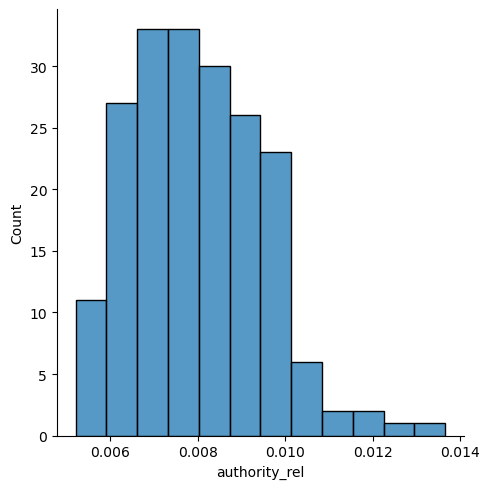

In [47]:
sns.displot(countryMFD, x='authority_rel')

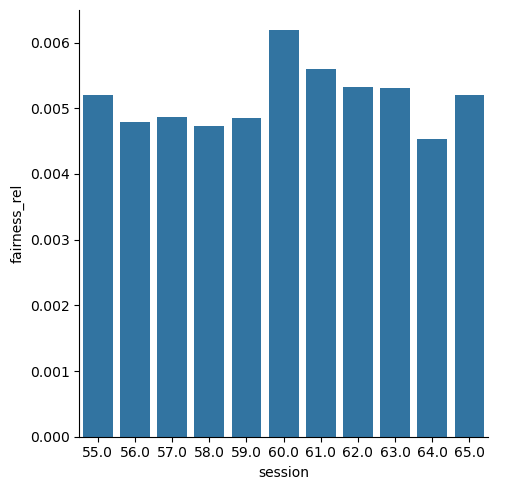

In [51]:
sns.catplot(sessionMFD, x='session', y='fairness_rel', kind='bar')

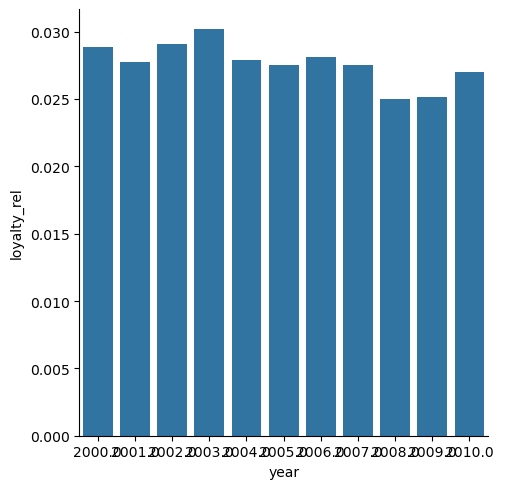

In [52]:
sns.catplot(yearMFD, x='year', y='loyalty_rel', kind='bar')

# Part 4: Sentiment Analysis as an example of dictionary approach 
- Sentiment analysis is a type of dictionary approach. 

In [59]:
# Function to analyze sentiment
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    return pd.Series([polarity, subjectivity])

# Apply sentiment analysis
dfUNSpeech[['polarity', 'subjectivity']] = dfUNSpeech['text'].apply(get_sentiment)

,id,text,isoAlpha,session,year,polarity,subjectivity
0,AFG_55_2000,"On my way to the\nAssembly Hall, I was informe...",AFG,55,2000,0.025418,0.440359
1,AFG_56_2001,"﻿At the outset, on\nbehalf of the Government o...",AFG,56,2001,0.131906,0.415076
2,AFG_57_2002,﻿Not very far from here stood\ntwo towers that...,AFG,57,2002,0.148450,0.379617
3,AFG_58_2003,﻿There is no reality more\noppressive than the...,AFG,58,2003,0.159920,0.460231
4,AFG_59_2004,Nelson Mandela once\ndescribed his countryís t...,AFG,59,2004,0.130954,0.422470
...,...,...,...,...,...,...,...
2074,ZWE_61_2006,Let me begin my statement \nby echoing the sen...,ZWE,61,2006,0.130634,0.396503
2075,ZWE_62_2007,Allow me to congratulate \nMr. Kerim on his el...,ZWE,62,2007,0.091776,0.401187
2076,ZWE_63_2008,I wish to begin by joining \nthose who have co...,ZWE,63,2008,0.060222,0.425588
2077,ZWE_64_2009,Let me begin by extending \nour warmest congra...,ZWE,64,2009,0.101169,0.357336


In [62]:
# Groupby and take mean of only integer columns
countryMFDSentiment = dfUNSpeech.groupby('isoAlpha')[['polarity', 'subjectivity']].mean().reset_index()
sessionMFDSentiment = dfUNSpeech.groupby('session')[['polarity', 'subjectivity']].mean()
yearMFDSentiment = dfUNSpeech.groupby('year')[['polarity', 'subjectivity']].mean()

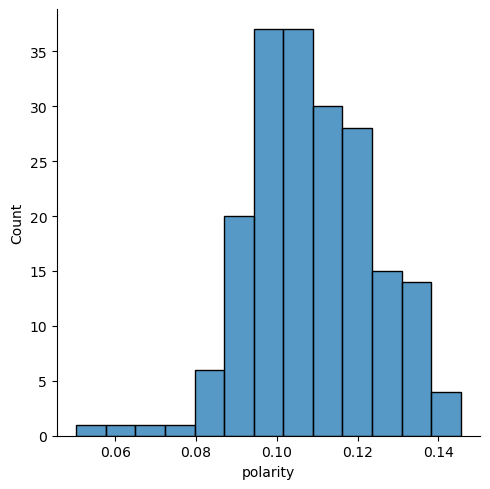

In [64]:
sns.displot(countryMFDSentiment, x='polarity')

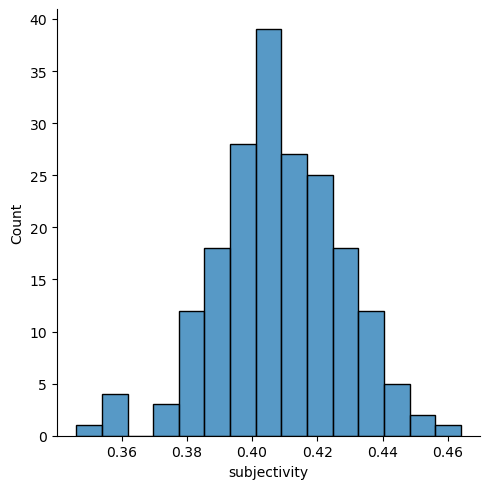

In [65]:
sns.displot(countryMFDSentiment, x='subjectivity')

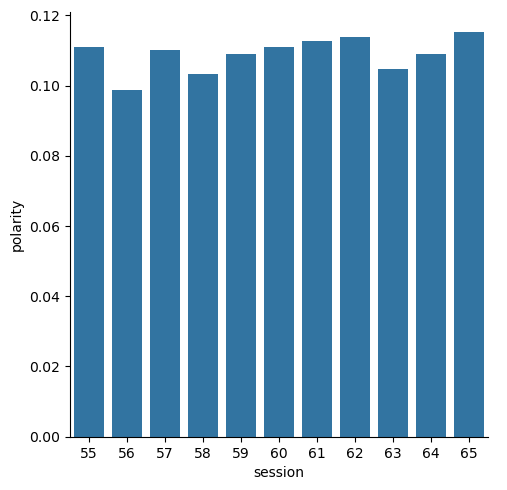

In [66]:
sns.catplot(sessionMFDSentiment, x='session', y='polarity', kind='bar')

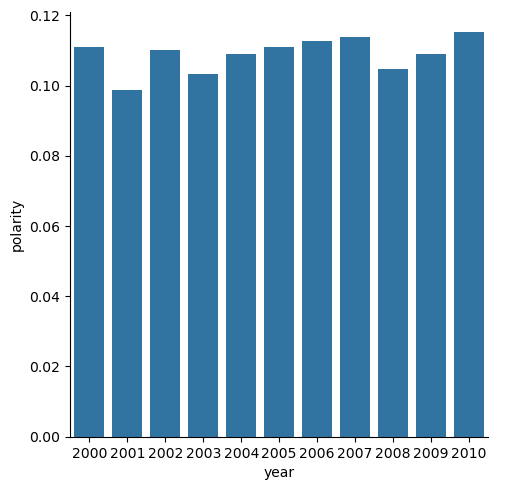

In [67]:
sns.catplot(yearMFDSentiment, x='year', y='polarity', kind='bar')